# Import the cobra toolbox

In [2]:
import cobra
from cobra import Model, Reaction, Metabolite

# Import the escher visualization package

In [3]:
import escher.urls
from IPython.display import HTML

# In this tutorial we will learn how to:

## 1) Simulate growth of a strain on different nutrient conditions
## 2) Manipulate the flux constraints of a reaction
## 3) Simulate gene knockouts _in silico_

### Import the e-coli model

In [53]:
IJO = cobra.io.load_json_model('iJO1366.json')

### A little more background on genome scale reconstructions

#####  Genome scale models simulate a flux state by optimizing for a biomass objective function given defined inputs.

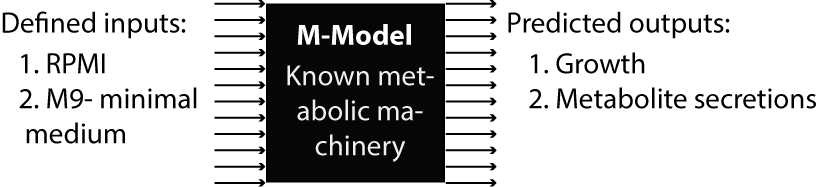

In [22]:
from IPython.display import Image
Image(filename='Tutorial_1 Black-box.png')

### In the following simulations, we will be simulating for growth in glucose + M9 minimal medium

#### What nutrients does the in-silico glucose + M9 minimal medium contain?

In [34]:
import pandas as pd

rows = {x.name.replace('exchange', ''): {
    'Reaction ID': x.id,
    'Lower Bound': x.lower_bound,
    'Upper Bound': x.upper_bound
}
       for x in IJO.reactions if x.id.startswith('EX') if x.lower_bound != 0
       }
pd.DataFrame.from_dict(rows, orient = 'index')
        

,Upper Bound,Lower Bound,Reaction ID
Ammonia,1000.0,-1000.00,EX_nh4_e
CO2,1000.0,-1000.00,EX_co2_e
Calcium,1000.0,-1000.00,EX_ca2_e
Chloride,1000.0,-1000.00,EX_cl_e
Co2+,1000.0,-1000.00,EX_cobalt2_e
Cob(I)alamin,1000.0,-0.01,EX_cbl1_e
Cu2+,1000.0,-1000.00,EX_cu2_e
D-Glucose,1000.0,-10.00,EX_glc__D_e
Fe2+,1000.0,-1000.00,EX_fe2_e
Fe3+,1000.0,-1000.00,EX_fe3_e


# 1 Simulate growth of a strain on different nutrient conditions

###### Glucose is the sole carbon source in the current medium definition. We will substitute glucose with galactose in the in silico medium.

In [138]:
solution = IJO.optimize()
print('Growth rate: %.2f'%solution.f)
solution_dict = {x:1 for x,y in dict(solution.fluxes).items() if y >0.01}
solution_dict.update({x:0 for x,y in dict(solution.fluxes).items() if y <0.01})

path = 'e_coli_core.Core metabolism.json'
# path = 'glycolysis.json'
escher_map = escher.Builder(map_json=path,reaction_data=dict(solution.fluxes),
                   # color and size according to the absolute value
                   reaction_styles=['color', 'size', 'abs', 'text'],
                   # change the default colors
                   reaction_scale=[{'type': 'min', 'color': '#cccccc', 'size': 4},
                                   {'type': 'mean', 'color': '#0000dd', 'size': 20},
                                   {'type': 'max', 'color': '#ff0000', 'size': 40}],
                   # only show the primary metabolites
                   hide_secondary_metabolites=True)
escher_map.display_in_notebook()

Growth rate: 0.98


## Substitute glucose with galactose as the sole carbon source

### First start by blocking the exchange of glucose

In [140]:
IJO.reactions.EX_glc__D_e.lower_bound = 0

### Proceed to open the exchange of galactose

In [141]:
print IJO.reactions.EX_gal_e.name
IJO.reactions.EX_gal_e.lower_bound = -10

D-Galactose exchange


In [142]:
solution = IJO.optimize()
print('Growth rate: %.2f'%solution.f)
solution_dict = {x:1 for x,y in dict(solution.fluxes).items() if y >0.01}
solution_dict.update({x:0 for x,y in dict(solution.fluxes).items() if y <0.01})

path = 'e_coli_core.Core metabolism.json'
# path = 'glycolysis.json'
escher_map = escher.Builder(map_json=path,reaction_data=dict(solution.fluxes),
                   # color and size according to the absolute value
                   reaction_styles=['color', 'size', 'abs', 'text'],
                   # change the default colors
                   reaction_scale=[{'type': 'min', 'color': '#cccccc', 'size': 4},
                                   {'type': 'mean', 'color': '#0000dd', 'size': 20},
                                   {'type': 'max', 'color': '#ff0000', 'size': 40}],
                   # only show the primary metabolites
                   hide_secondary_metabolites=True)
escher_map.display_in_notebook()

Growth rate: 0.97


### Now simulate growth through a selection of nutrients

In [126]:
IJO = cobra.io.load_json_model('iJO1366.json')


rows = {x.id: {
    'Nutrient': x.name.replace('exchange', '') ,
}
       for x in IJO.reactions if x.id.startswith('EX') if 'C' in x.metabolites.keys()[0].elements.keys()
       }
different_carbon_sources = pd.DataFrame.from_dict(rows, orient = 'index').iloc[10:20:]
      

for exchange in different_carbon_sources.index:
    IJO.reactions.get_by_id(exchange).lower_bound = -10
    solution = IJO.optimize().f
    different_carbon_sources.loc[exchange, 'Solution'] = solution
    IJO.reactions.get_by_id(exchange).lower_bound = 0

In [127]:
different_carbon_sources

,Nutrient,Solution
EX_2ddglcn_e,2-Dehydro-3-deoxy-D-gluconate,1.863748
EX_34dhpac_e,"3,4-Dihydroxyphenylacetaldehyde",0.982372
EX_3amp_e,3'-AMP,2.324636
EX_3cmp_e,3'-cmp,1.898842
EX_3gmp_e,3'-GMP,2.255098
EX_3hcinnm_e,3-hydroxycinnamic acid,2.161765
EX_3hpp_e,3-Hydroxypropanoate,0.982372
EX_3hpppn_e,3-(3-hydroxy-phenyl)propionate,2.203150
EX_3ump_e,3'-UMP,1.885720
EX_4abut_e,4-Aminobutanoate,1.661553


# 2 Constrain the flux through a reaction

#### In this step we will be constraining the flux through two different reactions; 
#### In one case, the model will predict that the reaction is essential and in the other case, it will predict that the reaction is not essential for growth

### First reaction:

In [9]:
print IJO.reactions.ACONTb.name
print 'Upper bound: ', IJO.reactions.ACONTb.upper_bound
print 'Lower bound: ', IJO.reactions.ACONTb.lower_bound
print 'The reaction is reversible.'

Aconitase (half-reaction B, Isocitrate hydro-lyase)
Upper bound:  1000.0
Lower bound:  -1000.0
The reaction is reversible.


### Constrain the flux by setting the upper and lower bounds to zero:

In [10]:
IJO.reactions.ACONTb.upper_bound = 0
IJO.reactions.ACONTb.lower_bound = 0

#### With both the upper and lower bound constrained to zero, there can be no flux running down this reaction. 

### Run Flux balance analysis

In [11]:
IJO.optimize().f

4.2221706427063453e-32

#### When the model predicts a growth rate of less than 0.01, we generally consider that the simulations yielded a no-growth phenotype

### Set the constraints back to their original values :
#### (One thousand is the value taken to represent infinity. The flux values will usually not reach that high)

In [13]:
IJO.reactions.ACONTb.upper_bound = 1000
IJO.reactions.ACONTb.lower_bound = -1000

### Second reaction:

In [21]:
print IJO.reactions.SUCDi.name
print 'Upper bound: ', IJO.reactions.SUCDi.upper_bound
print 'Lower bound: ', IJO.reactions.SUCDi.lower_bound
print 'The reaction is reversible.'

Succinate dehydrogenase (irreversible)
Upper bound:  1000
Lower bound:  -1000
The reaction is reversible.


### Constrain the flux by setting the upper and lower bounds to zero:

In [14]:
IJO.reactions.SUCDi.upper_bound = 0
IJO.reactions.SUCDi.lower_bound = 0

0.9566911236138236

### Run Flux balance analysis

In [117]:
IJO.optimize().f

0.9823718127269787

#### In this case, the model predicts a positive growth phenotype. Thus the reaction is not absolutely essential for survival in these conditions because there is a network redundancy. This phenomenon is widely observed across bacteria and is believed to be a mechanism to enhance survival.

### There is a shortcut way to constrain the flux through a reaction

In [131]:
IJO = cobra.io.load_json_model('iJO1366.json')
cobra.flux_analysis.single_reaction_deletion(IJO, ['ACONTb'])

,flux,status
ACONTb,9.545588e-18,optimal


## Constrain the flux through each reaction iteratively

In [134]:
results = cobra.flux_analysis.single_reaction_deletion(IJO)
results.head()

,flux,status
12DGR120tipp,0.982372,optimal
12DGR140tipp,0.982372,optimal
12DGR141tipp,0.982372,optimal
12DGR160tipp,0.982372,optimal
12DGR161tipp,0.982372,optimal


# 3 Simulate a gene knockout

#### A little more background knowledge on genome scale reconstruction:

##### During the reconstruction, one of the key elements that is added to each reaction is a gene reaction rule. This rule depicts the relation between a biochemical reaction and the enzyme(s) that catalyzes it. It can be derived from genome annotations as an initial draft but should ALWAYS be manually curated. This step in the reconstruction is crucial to attain a high accuracy in model driven predictions.

#### Do you remember the central dogma?

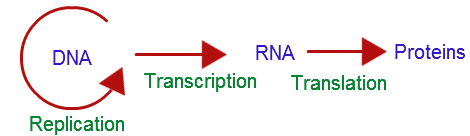

In [74]:
Image(filename='central-dogma.png')

##### There are two types of rules: 
#####  1) An single enzyme catalyzes a biochemical reaction

In [86]:
print IJO.reactions.PGI.name
IJO.reactions.PGI.gene_name_reaction_rule

Glucose-6-phosphate isomerase


u'pgi'

#####  2) the AND rule: When two or more enzymes need to work together (e.g. as a complex) to catalyze a reaction

In [85]:
print IJO.reactions.AKGDH.name
IJO.reactions.AKGDH.gene_name_reaction_rule

2-Oxogluterate dehydrogenase


u'lpd and sucA and sucB'

##### 3) the OR rule: When two or more enzymes can individually and independently catalyze a reaction (e.g. isozymes)

In [89]:
print IJO.reactions.PTAr.name
IJO.reactions.PTAr.gene_name_reaction_rule

Phosphotransacetylase


u'pta or eutD'

### Simulate a single gene knock out

In [97]:
cobra.flux_analysis.single_gene_deletion(IJO, IJO.reactions.PGI.genes)

,flux,status
b4025,0.976129,optimal


In [105]:
IJO = cobra.io.load_json_model('iJO1366.json')
print IJO.genes.b0118.name

rows = {rx.name:{
'Reaction ID': rx.id,
'Gene reaction rule': rx.gene_name_reaction_rule}
 for rx in IJO.genes.b0118.reactions
}
pd.DataFrame.from_dict(rows, orient = 'index')

acnB


,Gene reaction rule,Reaction ID
2-methylisocitrate dehydratase,acnB,MICITDr
"Aconitase (half-reaction A, Citrate hydro-lyase)",acnB or acnA,ACONTa
"Aconitase (half-reaction B, Isocitrate hydro-lyase)",acnB or acnA,ACONTb


In [106]:
cobra.flux_analysis.single_gene_deletion(IJO, ['b0118'])

,flux,status
b0118,0.982372,optimal


### Simulate a double gene knock out

In [109]:
IJO = cobra.io.load_json_model('iJO1366.json')
cobra.flux_analysis.double_gene_deletion(IJO, ['b0118', 'b1276'], return_frame=True).round(4)

,b0118,b1276
b0118,0.9824,0.0000
b1276,0.0000,0.9824


### Find the conditionally essential genes

In [111]:
IJO = cobra.io.load_json_model('iJO1366.json')
deletion_results = cobra.flux_analysis.single_gene_deletion(IJO)

In [114]:
deletion_results.loc[deletion_results['flux'] < 0.01]

,flux,status
b0003,5.482611e-16,optimal
b0004,5.684981e-17,optimal
b0009,2.402233e-15,optimal
b0025,6.496251e-17,optimal
b0029,0.000000e+00,optimal
b0031,0.000000e+00,optimal
b0052,-1.392693e-15,optimal
b0071,-1.228123e-13,optimal
b0072,-1.228123e-13,optimal
b0073,-1.228123e-13,optimal
